# cis-isoQTL analysis
After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot
- Compare sig feature across ancestries, upsetR
- Venn graph for fetal vs PEC, GTEx
- isoGene type
- Conditional pass
- Susie

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))

In [2]:
setwd("~/project-gandalm/isoform_twas/isoqtl_new/")

### 1: Optimal number of HCP

#### Mixed ancestry

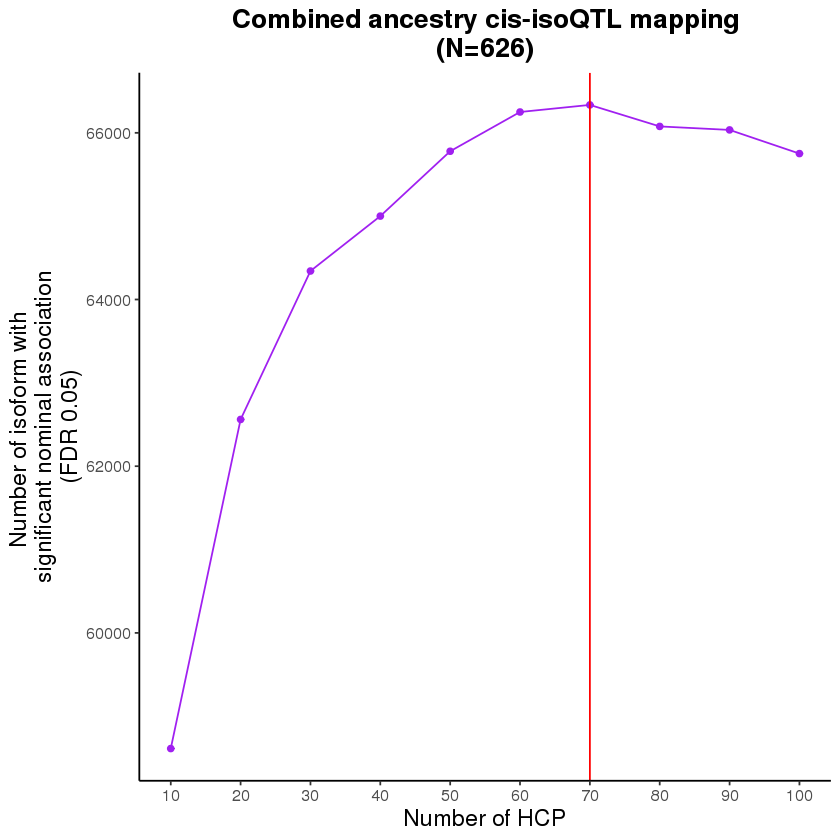

In [4]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 70, color = "red") +
    labs(title = "Combined ancestry cis-isoQTL mapping\n(N=626)",
         x = "Number of HCP",
         y = "Number of isoform with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [5]:
ggsave("figures/mixed_nominal.png", p1, width = 6, height = 6)

#### EUR

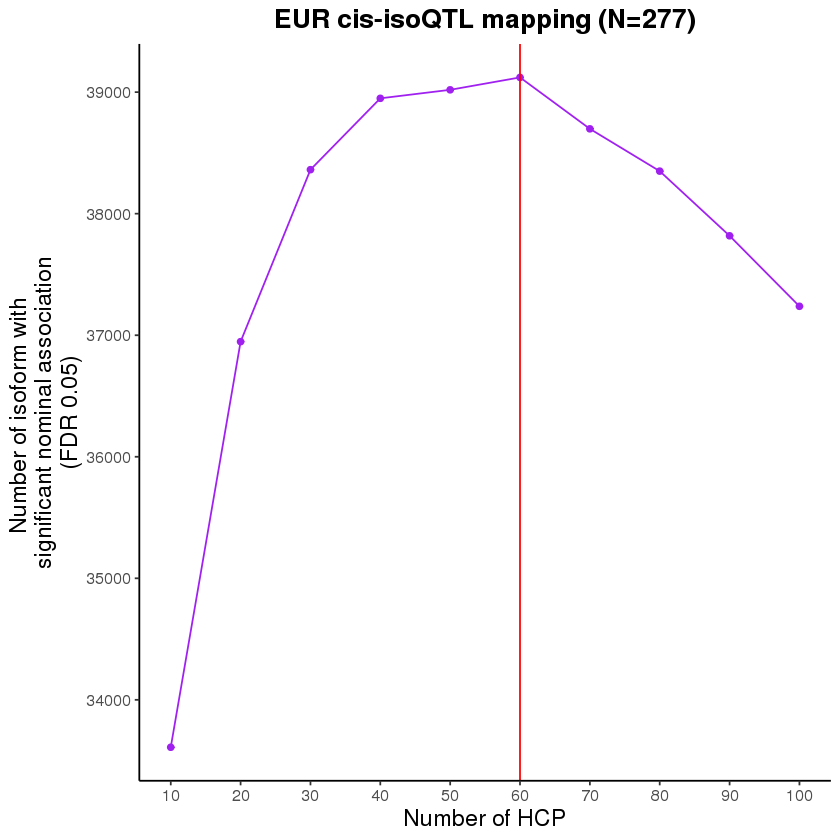

In [4]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 60, color = "red") +
    labs(title = "EUR cis-isoQTL mapping (N=277)",
         x = "Number of HCP",
         y = "Number of isoform with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3

In [5]:
ggsave("figures/eur_nominal.png", p3, width = 6, height = 6)

#### AMR

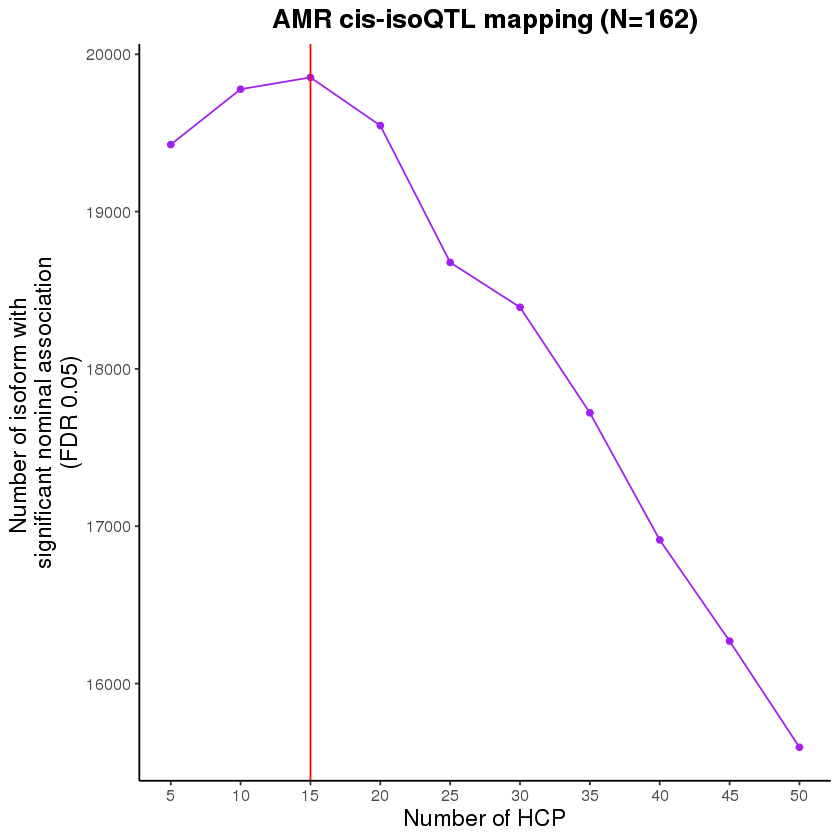

In [7]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR cis-isoQTL mapping (N=162)",
         x = "Number of HCP",
         y = "Number of isoform with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p4

In [8]:
ggsave("figures/amr_nominal.png", p4, width = 6, height = 6)

#### AFR

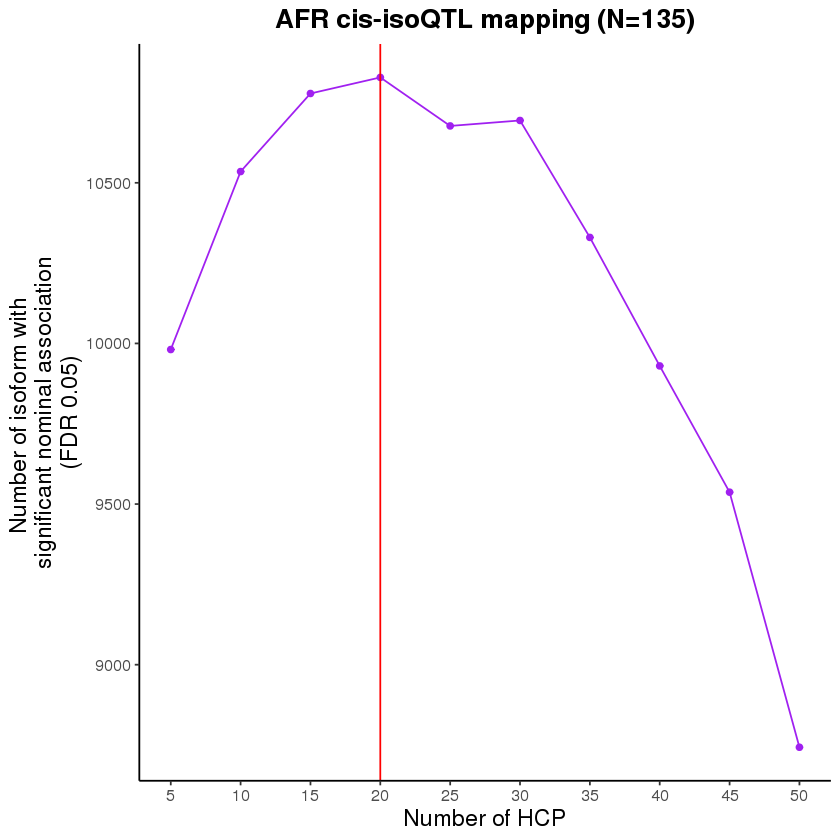

In [9]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p5 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 20, color = "red") +
    labs(title = "AFR cis-isoQTL mapping (N=135)",
         x = "Number of HCP",
         y = "Number of isoform with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p5

In [10]:
ggsave("figures/afr_nominal.png", p5, width = 6, height = 6)

### 2: Isoform expression regression, check batch effects

#### Mixed ancestry

In [2]:
rel <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]

Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/tx.counts.processed.tsv", :
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/tx.counts.processed.noComBat.tsv", :
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  77 626

[1] 127986    626

[1] 127986    626

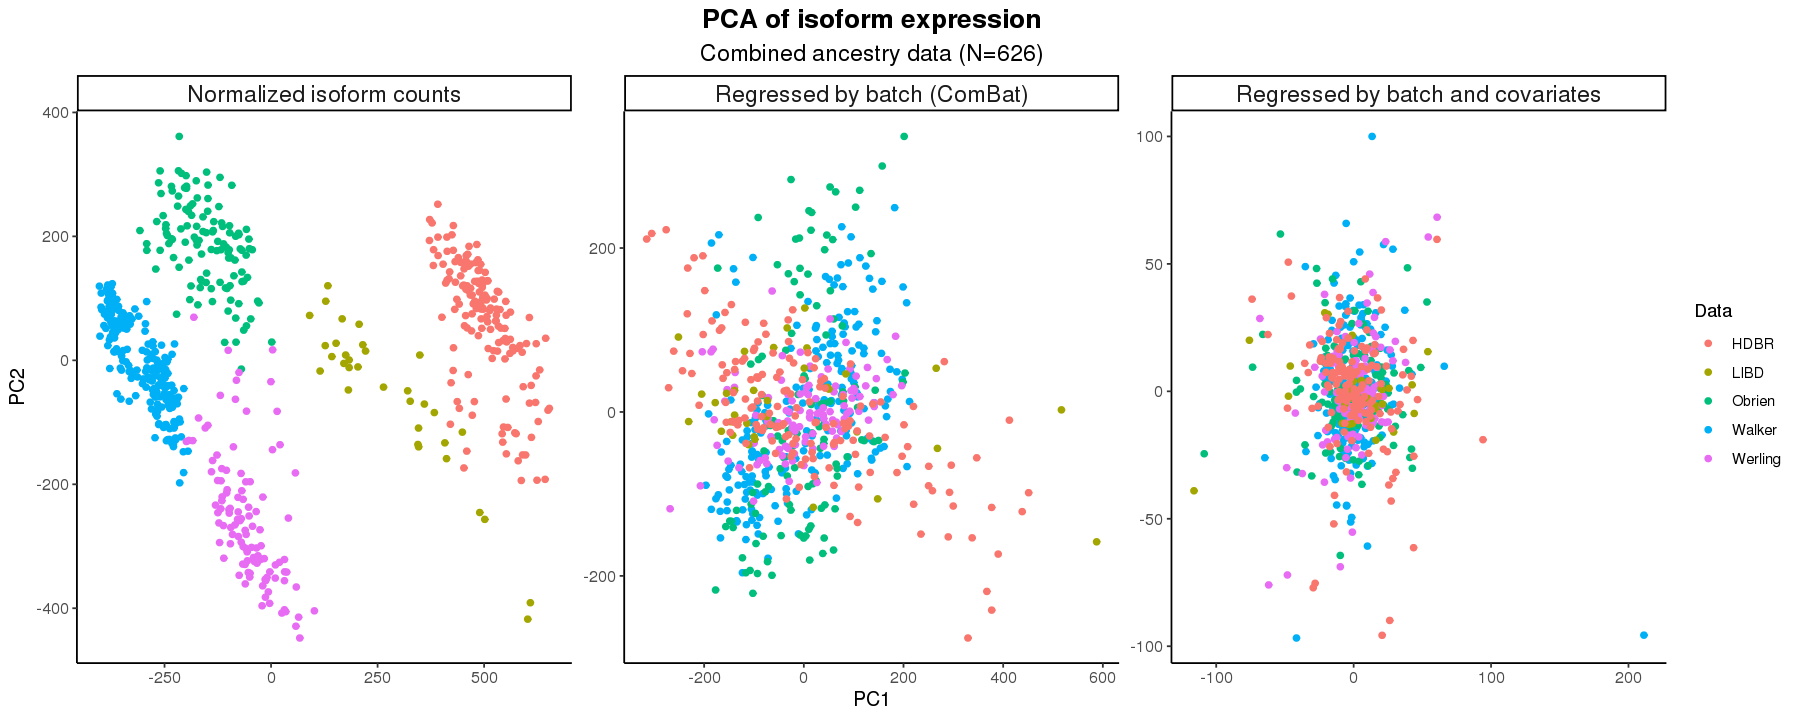

In [7]:
datExpr <- fread("data/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/70hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of isoform expression",
       subtitle = "Combined ancestry data (N=626)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [8]:
ggsave("figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/eur/tx.counts.processed.tsv", :
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/eur/tx.counts.processed.noComBat.tsv", :
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  67 277

[1] 127986    277

[1] 127986    277

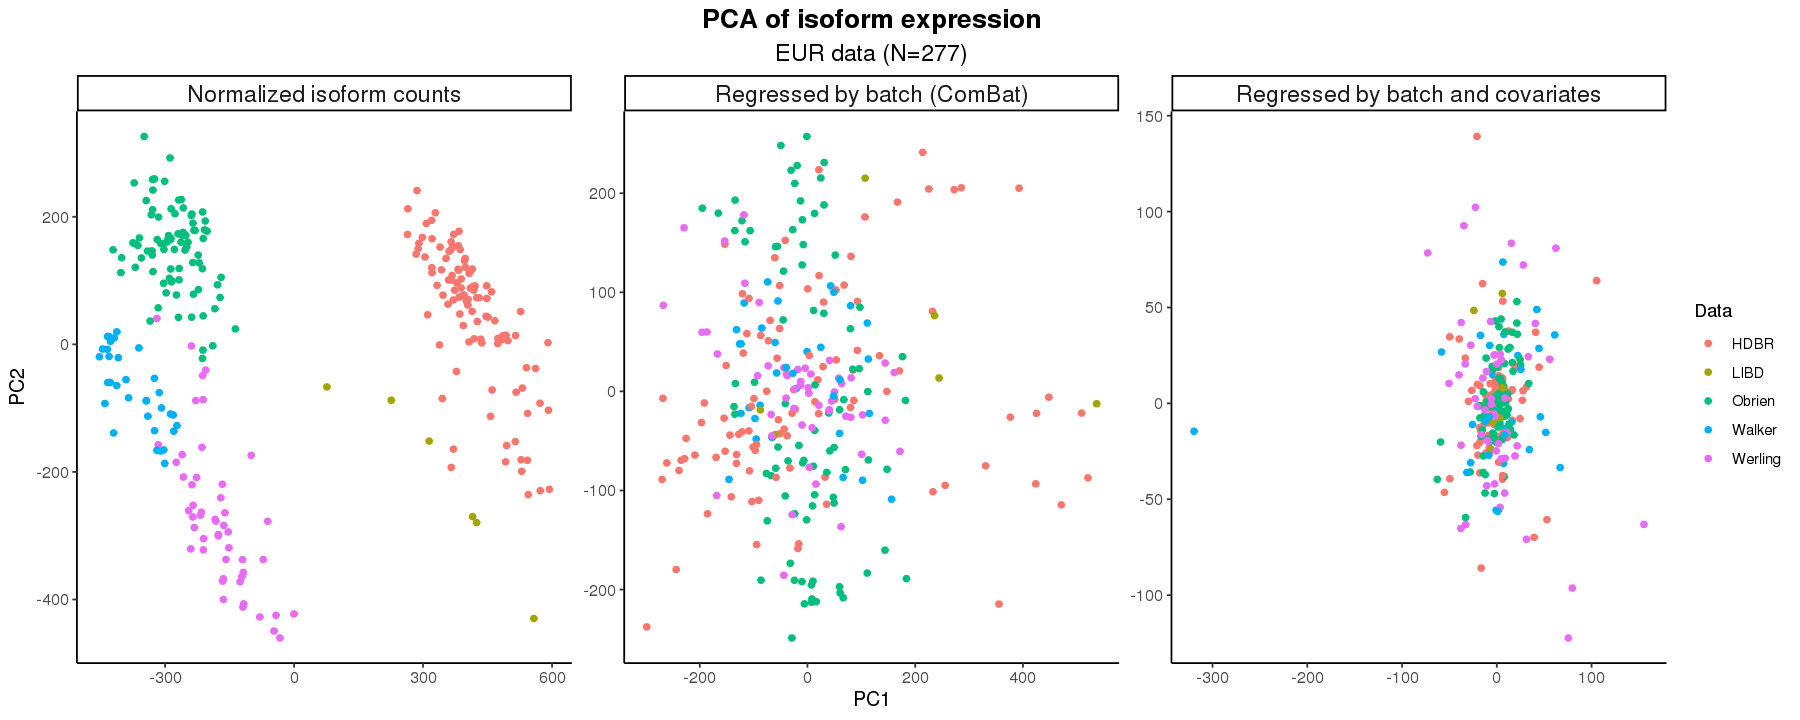

In [6]:
datExpr <- fread("data/eur/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/eur/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/eur/60HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p6 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of isoform expression",
       subtitle = "EUR data (N=277)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p6

In [7]:
ggsave("figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

In [4]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/amr/tx.counts.processed.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/amr/tx.counts.processed.noComBat.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 127986    162

[1] 127986    162

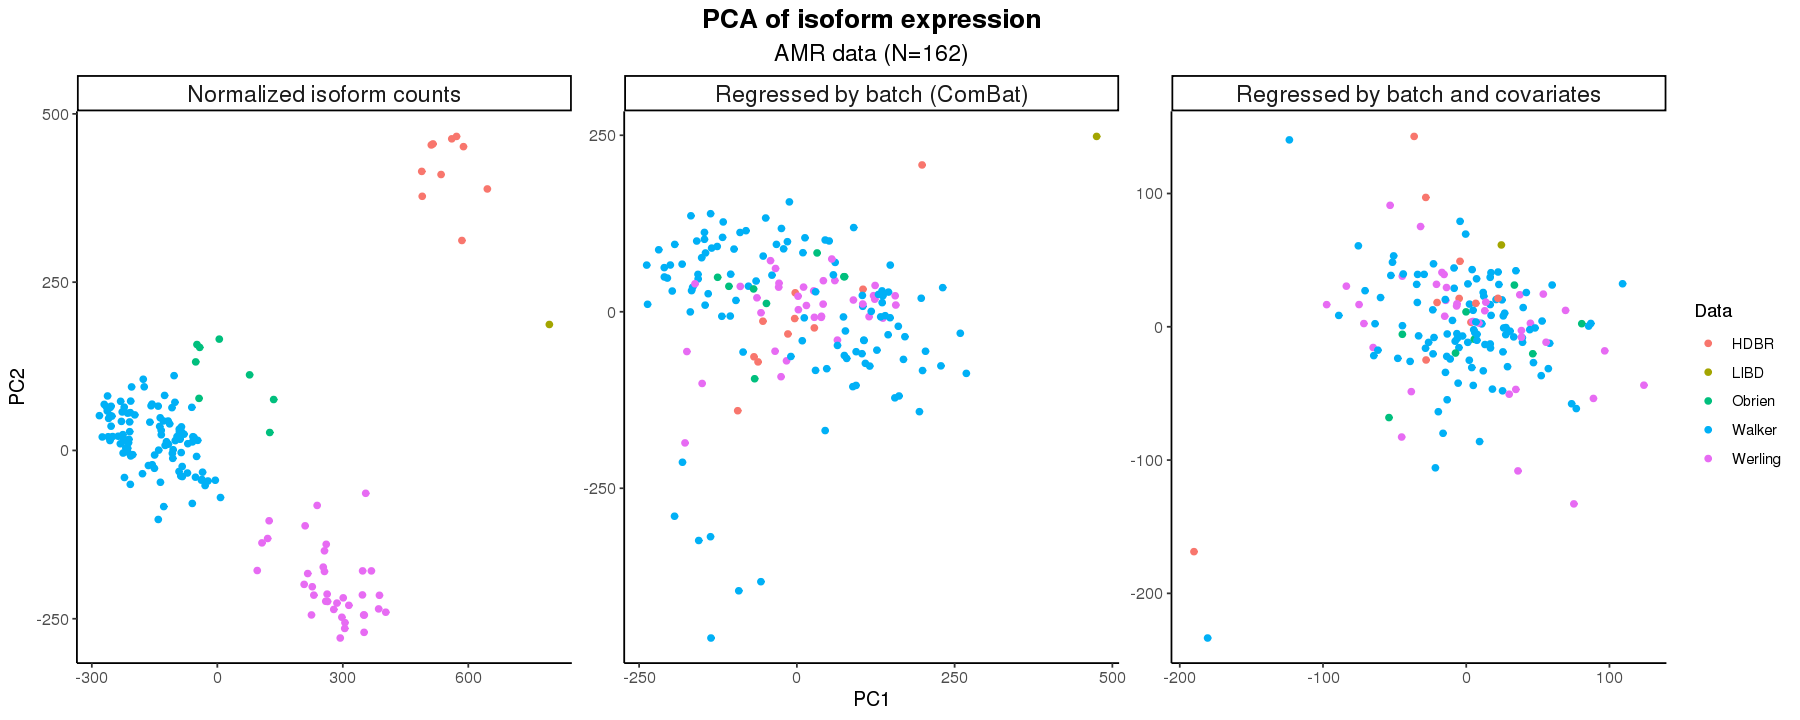

In [5]:
datExpr <- fread("data/amr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/amr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p7 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of isoform expression",
       subtitle = "AMR data (N=162)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p7

In [6]:
ggsave("figures/amr_regress.png", p7, width = 15, height = 6)

#### AFR

Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/afr/tx.counts.processed.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/isoqtl_new/data/afr/tx.counts.processed.noComBat.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  27 135

[1] 127986    135

[1] 127986    135

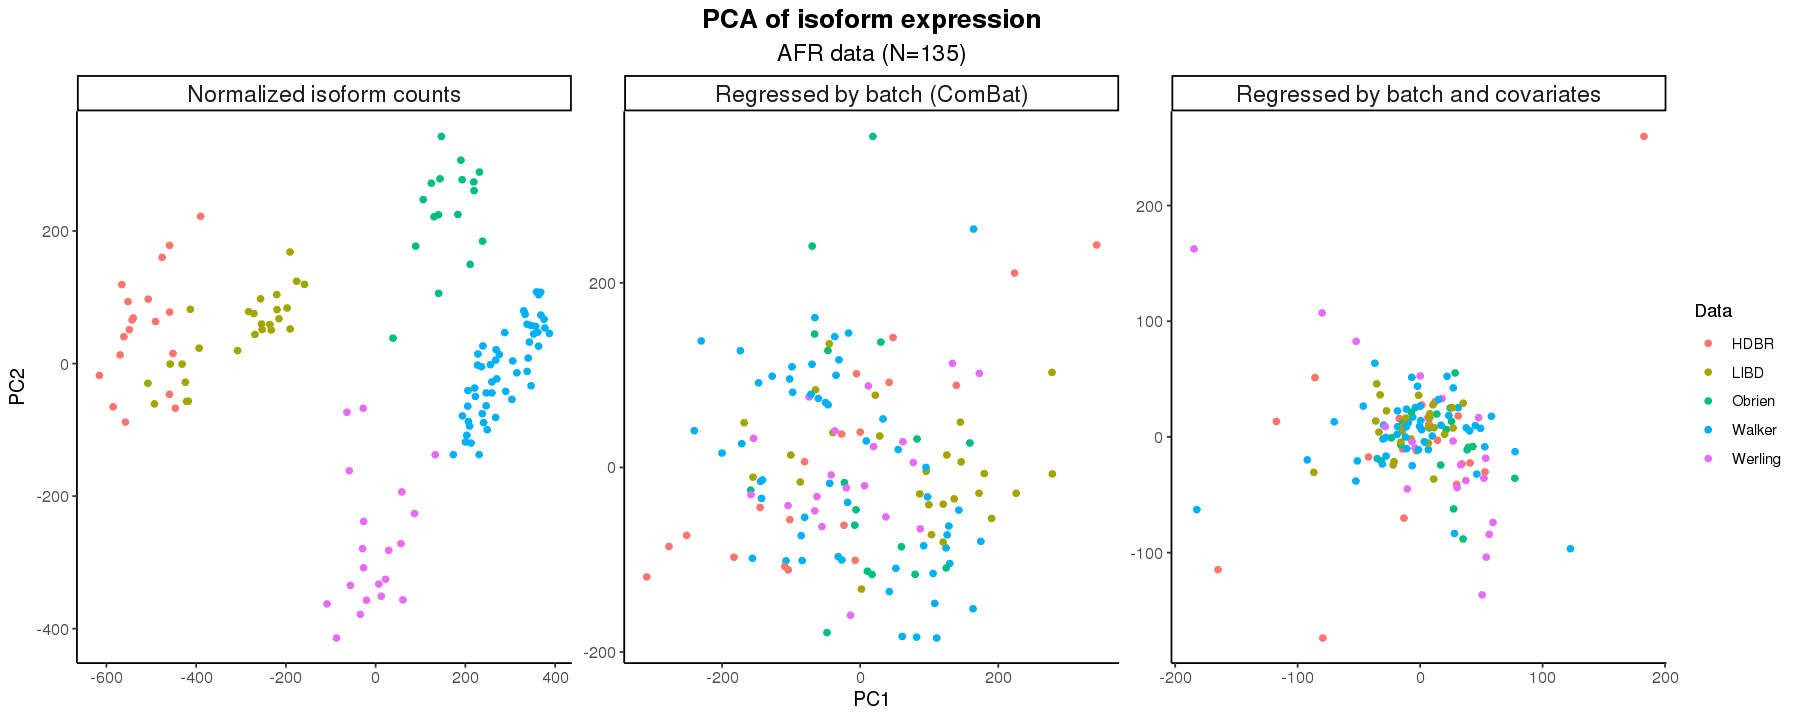

In [10]:
datExpr <- fread("data/afr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/afr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/afr/20HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p8 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of isoform expression",
       subtitle = "AFR data (N=135)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p8

In [11]:
ggsave("figures/afr_regress.png", p8, width = 15, height = 6)

### 3: Check beta-approximated permutation pval

[1] 0.9999

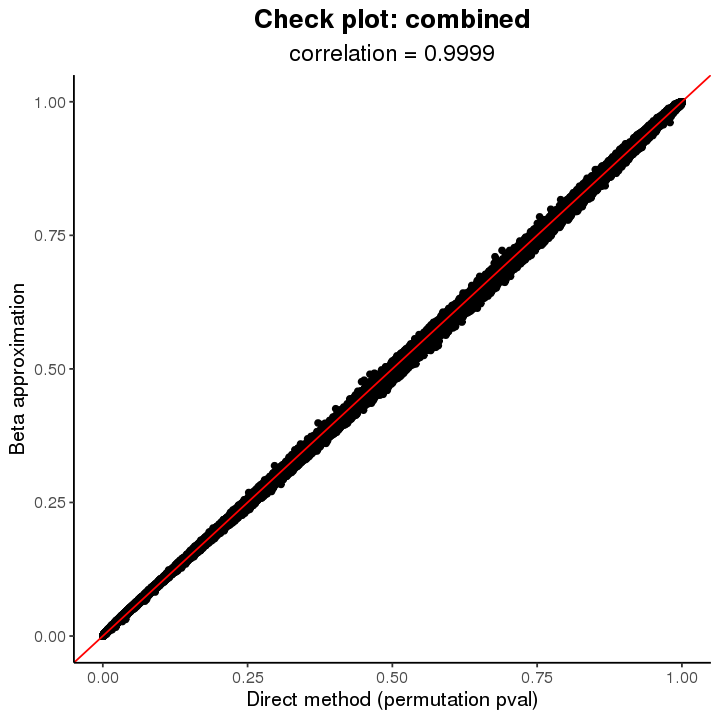

In [10]:
options(repr.plot.width=6, repr.plot.height=6)

mixed <- fread("results/mixed_perm_70hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(mixed[, 'ppval'], mixed[, 'bpval']), 4)
p <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: combined",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [11]:
ggsave("figures/mixed_check.png", p, width = 6, height = 6)

[1] 0.9998

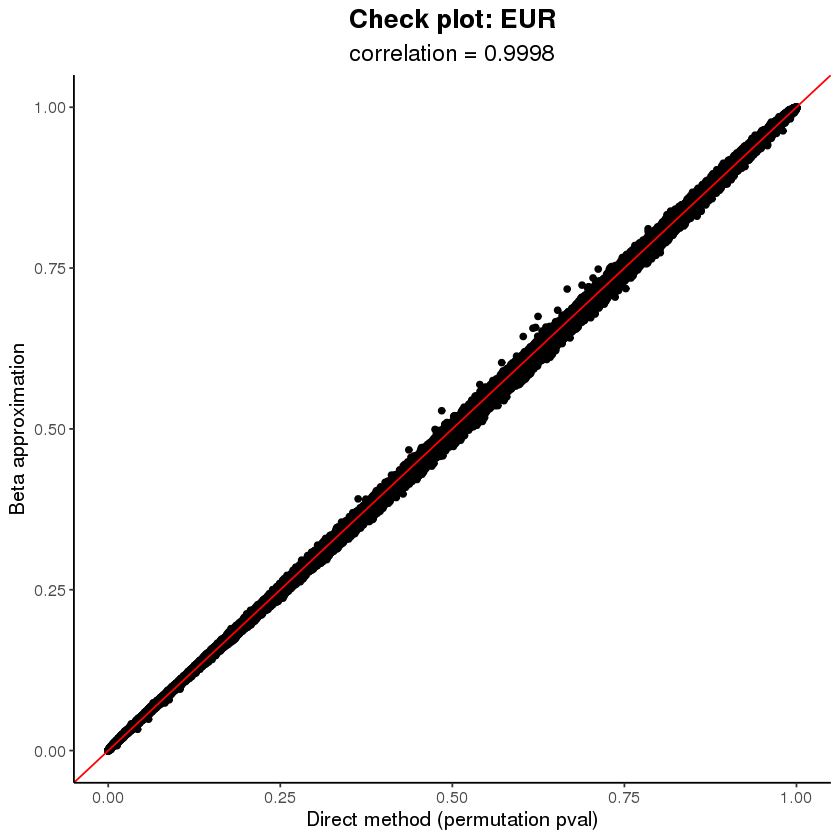

In [2]:
eur <- fread("results/eur_perm_60HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(eur[, 'ppval'], eur[, 'bpval']), 4)
p1 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: EUR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("figures/eur_check.png", p1, width = 6, height = 6)

[1] 0.9998

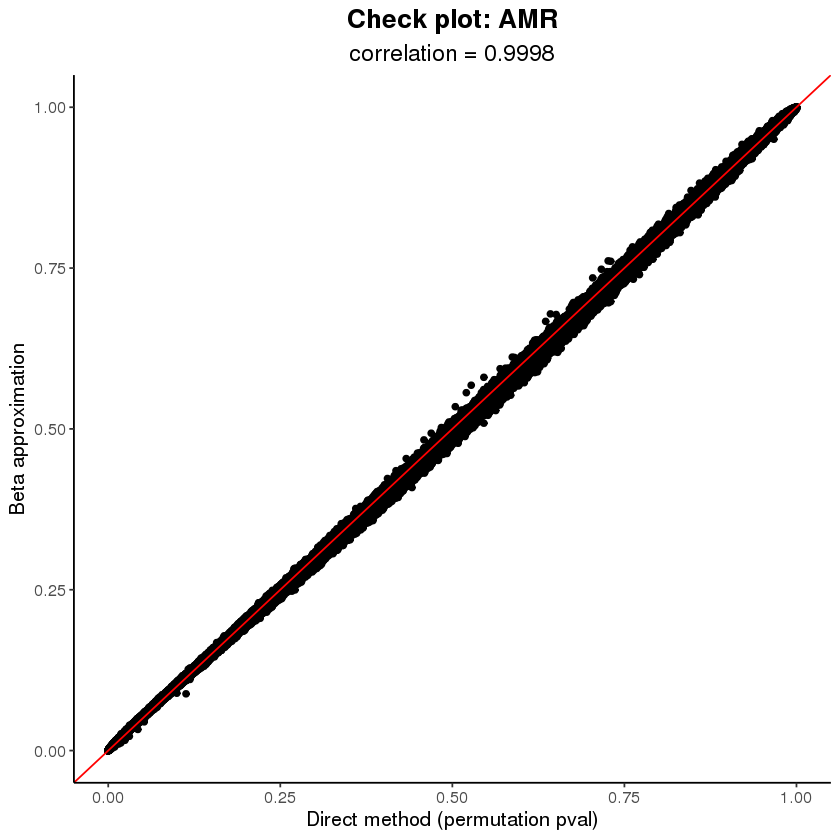

In [3]:
amr <- fread("results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(amr[, 'ppval'], amr[, 'bpval']), 4)
p2 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AMR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("figures/amr_check.png", p2, width = 6, height = 6)

[1] 0.9998

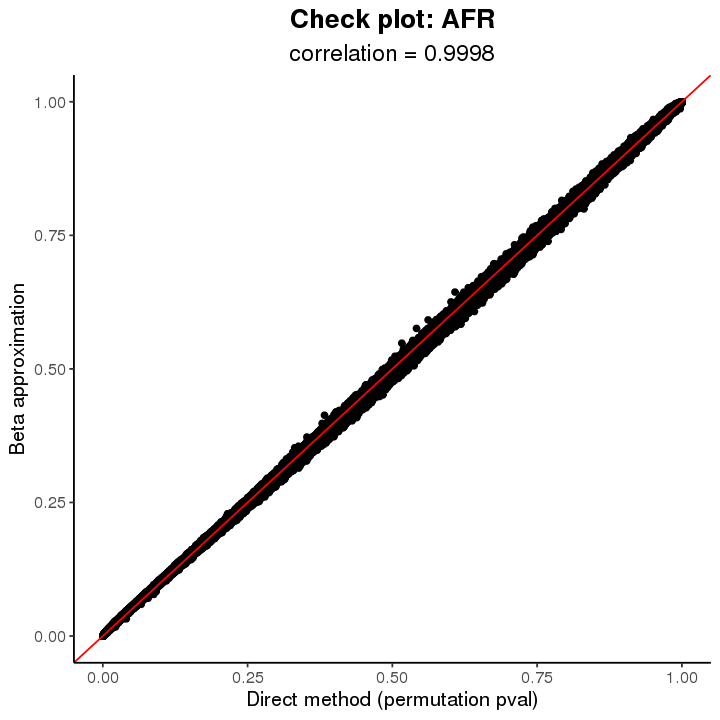

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
afr <- fread("results/afr_perm_20HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(afr[, 'ppval'], afr[, 'bpval']), 4)
p3 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AFR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("figures/afr_check.png", p3, width = 6, height = 6)

### 4: top isoQTL per isoform dTSS to its target isoform

In [26]:
mixed_sig <- read.table("results/mixed_perm_70hcp/sig_pheno_gene.txt", header = T, stringsAsFactors = F)

In [4]:
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,Gene
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENST00000002165.11_3,5683,1.04270,863.673,478.732,rs4896658,-47658,1.04606e-17,-0.814467,0.00009999,2.84572e-13,3.88533e-12,2.30536e-05,ENSG00000001036
2,ENST00000002501.11_2,4247,1.08405,461.862,450.821,rs78536691,14607,8.12818e-07,-0.476499,0.00159984,2.08651e-03,8.58905e-03,5.10417e-05,ENSG00000003249
3,ENST00000002596.6_3,7427,1.04532,878.552,477.103,rs57203756,256802,2.62013e-06,-0.696909,0.00759924,7.96587e-03,2.76269e-02,2.29153e-05,ENSG00000002587
4,ENST00000003100.13_4,4221,1.01913,520.765,479.814,rs34040612,35125,3.26734e-15,-0.201914,0.00009999,5.24469e-11,5.89738e-10,3.45304e-05,ENSG00000001630
5,ENST00000003302.8_2,5184,1.04422,804.917,483.553,rs7126080,-21619,2.00629e-09,0.231246,0.00009999,8.26057e-06,5.23915e-05,2.48958e-05,ENSG00000048028
6,ENST00000003583.12_2,5651,1.05037,809.344,475.954,rs11578878,-9278,3.09987e-34,0.523475,0.00009999,1.96434e-28,7.14212e-27,2.54073e-05,ENSG00000001460


In [5]:
dim(mixed_sig)

[1] 22891    14

In [8]:
df <- data.frame("gene" <- unique(mixed_sig$Gene), "num_tx" <- NA)
colnames(df) <- c("gene", "num_tx")
head(df)

,gene,num_tx
,<fct>,<lgl>
1,ENSG00000001036,NA
2,ENSG00000003249,NA
3,ENSG00000002587,NA
4,ENSG00000001630,NA
5,ENSG00000048028,NA
6,ENSG00000001460,NA


In [9]:
for (i in 1:nrow(df)) {
    df[i,2] <- sum(mixed_sig$Gene == df[i,1])
}
head(df)

,gene,num_tx
,<fct>,<int>
1,ENSG00000001036,1
2,ENSG00000003249,2
3,ENSG00000002587,1
4,ENSG00000001630,1
5,ENSG00000048028,2
6,ENSG00000001460,6


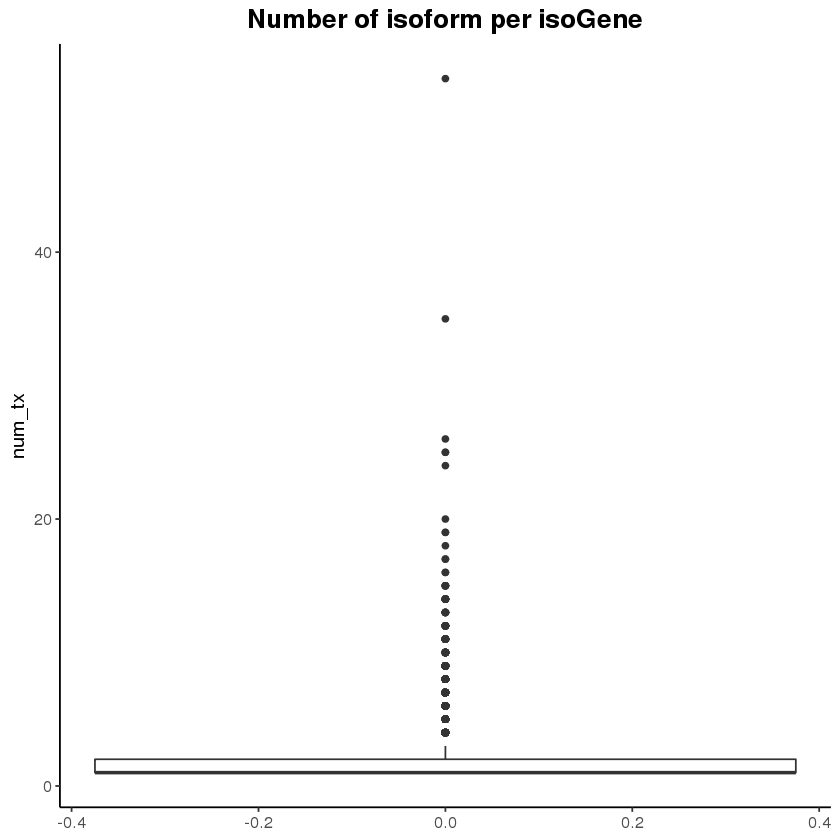

In [10]:
p <- ggplot(df, aes(y=num_tx)) +
    geom_boxplot() +
    labs(title = "Number of isoform per isoGene") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [13]:
summary(df$num_tx)
head(df %>% arrange(desc(num_tx)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.996   2.000  53.000 

,gene,num_tx
,<fct>,<int>
1,ENSG00000242086,53
2,ENSG00000259905,35
3,ENSG00000224078,26
4,ENSG00000170919,25
5,ENSG00000197912,25
6,ENSG00000196295,24


In [8]:
# mixed_sig <- mixed_sig %>% arrange(Gene, bpval)
# top <- mixed_sig[!duplicated(mixed_sig$Gene),]

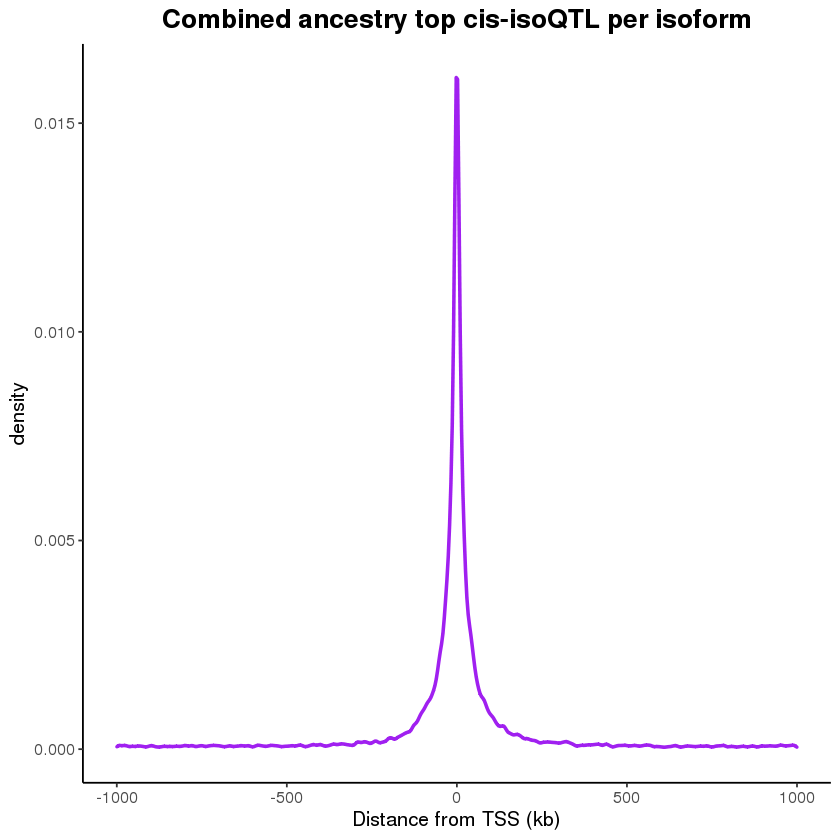

In [6]:
mixed_sig$dist_kb <- mixed_sig$dist/1000
p <- ggplot(mixed_sig, aes(x = dist_kb)) +
    geom_density(color = "purple", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "Combined ancestry top cis-isoQTL per isoform") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [5]:
ggsave("figures/mixed_dist.png", p, height = 6, width = 6)

[1] 11672    14

[1] 11672

[1] 6885

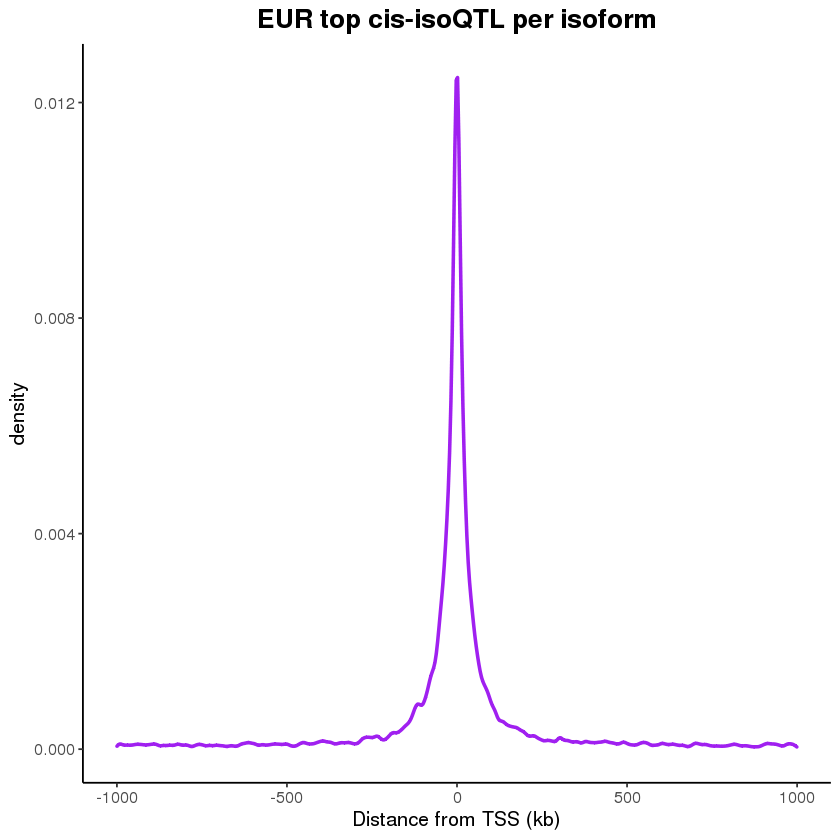

In [6]:
eur_sig <- read.table("results/eur_perm_60HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
tx2gene <- read.table("~/project-gandalm/isoform_twas/salmon/tx2gene_gencode_v33_noGeneVersion.tsv", header=T, stringsAsFactors=F)
eur_sig <- eur_sig %>% left_join(tx2gene, by=c("pid"="Tx"))
write.table(eur_sig, "results/eur_perm_60HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
dim(eur_sig)
length(unique(eur_sig$pid))
length(unique(eur_sig$Gene))

# eur_sig <- eur_sig %>% arrange(Gene, bpval)
# eur_top <- eur_sig[!duplicated(eur_sig$Gene),]
eur_sig$dist_kb <- eur_sig$dist/1000
p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
    geom_density(color = "purple", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "EUR top cis-isoQTL per isoform") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("figures/eur_dist.png", p1, height = 6, width = 6)

[1] 3989

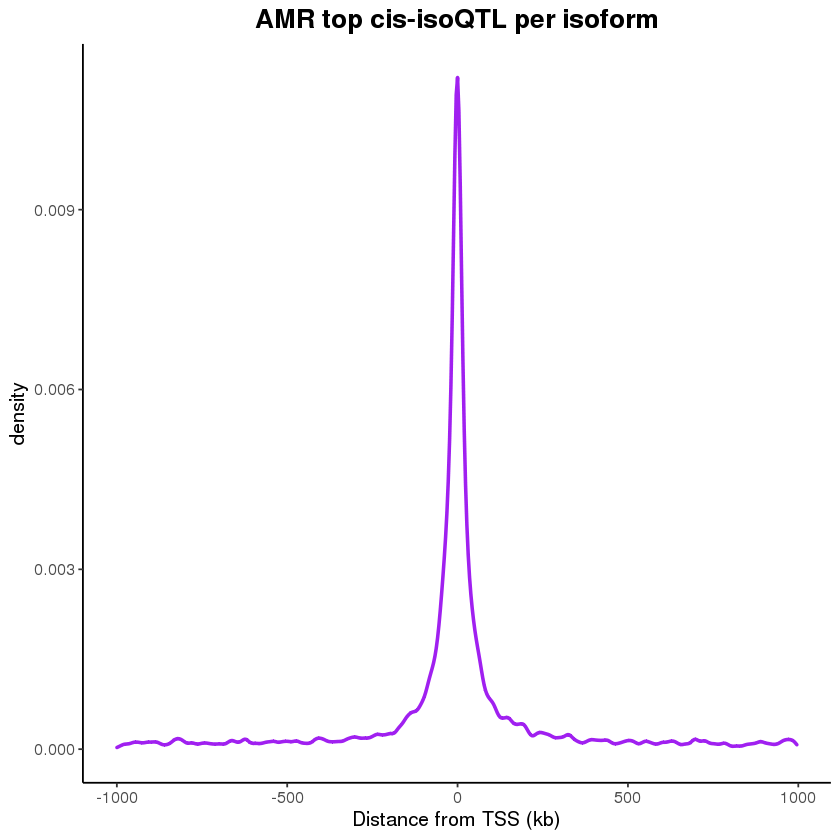

In [7]:
amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
amr_sig <- amr_sig %>% left_join(tx2gene, by=c("pid"="Tx"))
write.table(amr_sig, "results/amr_perm_15HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
length(unique(amr_sig$Gene))

# amr_sig <- amr_sig %>% arrange(Gene, bpval)
# amr_top <- amr_sig[!duplicated(amr_sig$Gene),]
amr_sig$dist_kb <- amr_sig$dist/1000
p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
    geom_density(color = "purple", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AMR top cis-isoQTL per isoform") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("figures/amr_dist.png", p2, height = 6, width = 6)

[1] 2682

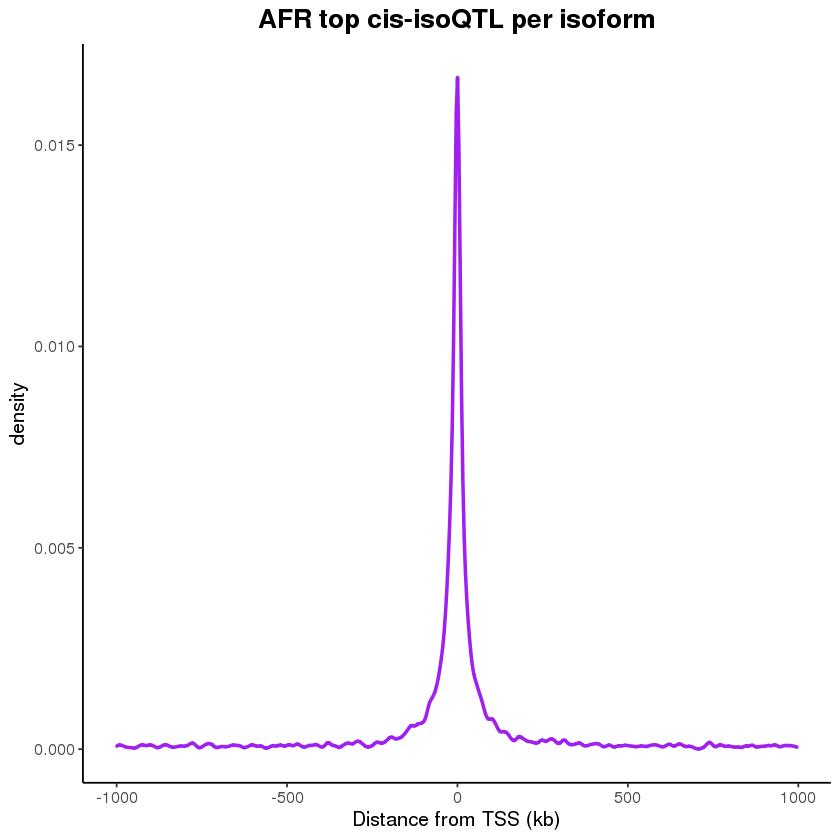

In [8]:
afr_sig <- read.table("results/afr_perm_20HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
tx2gene <- read.table("~/project-gandalm/isoform_twas/salmon/tx2gene_gencode_v33_noGeneVersion.tsv", header=T, stringsAsFactors=F)
afr_sig <- afr_sig %>% left_join(tx2gene, by=c("pid"="Tx"))
write.table(afr_sig, "results/afr_perm_20HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
length(unique(afr_sig$Gene))

# afr_sig <- afr_sig %>% arrange(Gene, bpval)
# afr_top <- afr_sig[!duplicated(afr_sig$Gene),]
afr_sig$dist_kb <- afr_sig$dist/1000
p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
    geom_density(color = "purple", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AFR top cis-isoQTL per isoform") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("figures/afr_dist.png", p3, height = 6, width = 6)

### 5: Ancestry isoTx/isoGene UpsetR

In [14]:
eur_sig <- read.table("results/eur_perm_60HCP/sig_pheno_gene.txt", header = T, stringsAsFactors = F)
amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno_gene.txt", header = T, stringsAsFactors = F)
afr_sig <- read.table("results/afr_perm_20HCP/sig_pheno_gene.txt", header = T, stringsAsFactors = F)

In [15]:
mixed_tx <- unique(mixed_sig$pid)
eur_tx <- unique(eur_sig$pid)
amr_tx <- unique(amr_sig$pid)
afr_tx <- unique(afr_sig$pid)

tx <- list(Combined = mixed_tx,
            EUR = eur_tx,
            AMR = amr_tx,
            AFR = afr_tx)

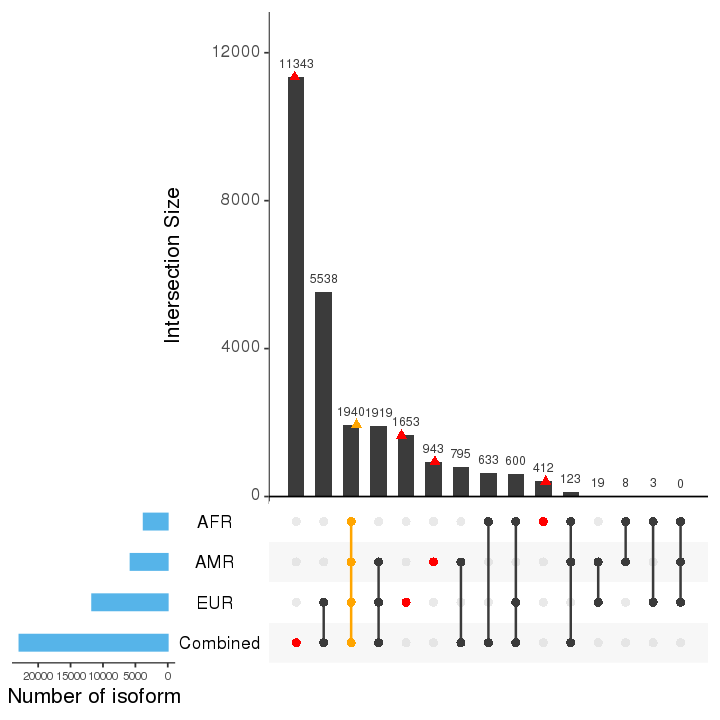

In [17]:
upset(fromList(tx), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoform",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [18]:
pdf(file="figures/upsetr_isotx.pdf", onefile=F)
upset(fromList(tx), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoform",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

In [20]:
mixed_gene <- unique(mixed_sig$Gene)
eur_gene <- unique(eur_sig$Gene)
amr_gene <- unique(amr_sig$Gene)
afr_gene <- unique(afr_sig$Gene)

genes <- list(Combined = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

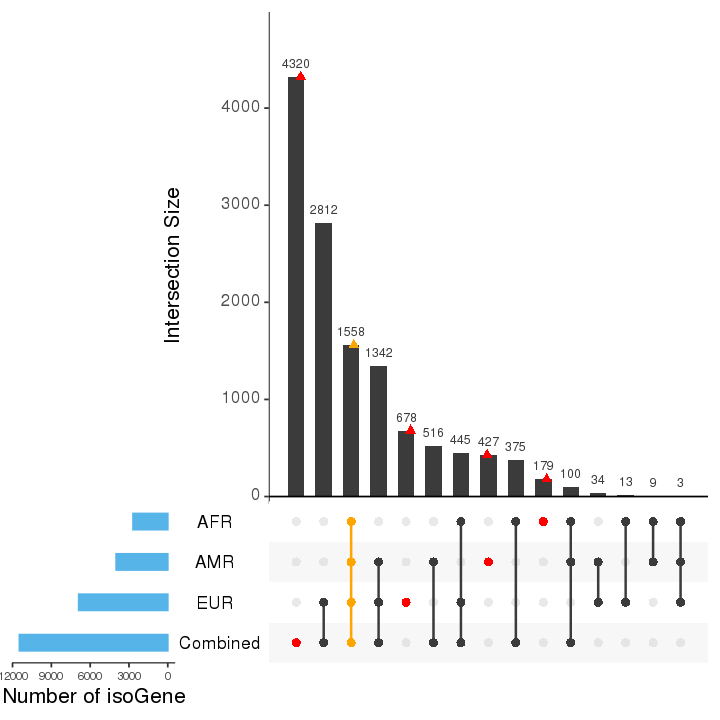

In [21]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [22]:
pdf(file="figures/upsetr_isogene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

### 6: Compare with PEC

### 7: isoGene types

In [7]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [12]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("Gene"="ensg"))

In [13]:
dim(mixed_sig)
# no dtss_kb, 26 columns
# in eqtl_analysis.ipynb, info file has column dtss_kb

[1] 22891    26

In [14]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"

In [20]:
write.table(mixed_sig, "results/mixed_perm_70hcp/sig_pheno_gene_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [15]:
mixed_sig <- mixed_sig[!duplicated(mixed_sig$Gene),]

In [16]:
dim(mixed_sig)

[1] 11468    16

In [17]:
df <- as.data.frame(sort(table(mixed_sig$gene_type)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df

,Var1,Freq
,<fct>,<int>
25,protein_coding,8074
24,lncRNA,2207
23,processed_pseudogene,323
22,transcribed_unprocessed_pseudogene,238


### 8: Conditional isoQTL

** Top variants per rank of all expressed isoforms **

In [22]:
dat <- fread("results/mixed_conditional_70hcp/conditional_top_variants.txt", data.table = F)

In [5]:
head(dat)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,ENST00000440313.2_2,11,71806036,71806036,+,4779,-202931,rs141178310,11,71603105,71603105,0,3.17390e-05,1.2141300,1,1,3.17390e-05,1.2141300,1,1
2,ENST00000545249.5_2,11,71814292,71814292,+,4788,25755,rs58417942,11,71840047,71840047,0,1.90065e-05,0.0967911,1,1,1.90065e-05,0.0967911,1,1
3,ENST00000537656.1_1,11,71939893,71939893,+,5058,127377,rs112371691,11,72067270,72067270,0,2.43695e-06,-0.6123260,1,1,2.43695e-06,-0.6123260,1,1
4,ENST00000645650.1_2,11,72063610,72063610,+,5417,-367725,rs142516903,11,71695885,71695885,0,2.94189e-05,1.0293600,1,1,2.94189e-05,1.0293600,1,1
5,ENST00000544683.5_3,11,72141538,72141538,+,5366,-705517,rs11827917,11,71436021,71436021,0,1.01401e-06,-0.8326320,1,1,1.01401e-06,-0.8326320,1,1
6,ENST00000536918.1_2,11,72290549,72290549,+,5292,80,rs392565,11,72290629,72290629,0,1.82355e-10,0.4078950,1,1,1.82355e-10,0.4078950,1,1


In [23]:
table(dat$V19)
table(dat$V20)


    1 
36919 


    0     1 
  345 36574 

** remove variants with backward P-value that is not below the threshold of this feature **

In [24]:
dat <- dat %>% filter(V20 == 1)

** check features with significant conditional QTL are mostly isoforms with permutation isoQTL **

In [27]:
length(unique(mixed_sig$pid))
length(unique(dat$V1))
sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 22891

[1] 28195

[1] 20132

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [15]:
table(dat$V12)


    0     1     2     3     4     5     6     7     8 
27285  6816  1708   544   155    48    12     4     2 

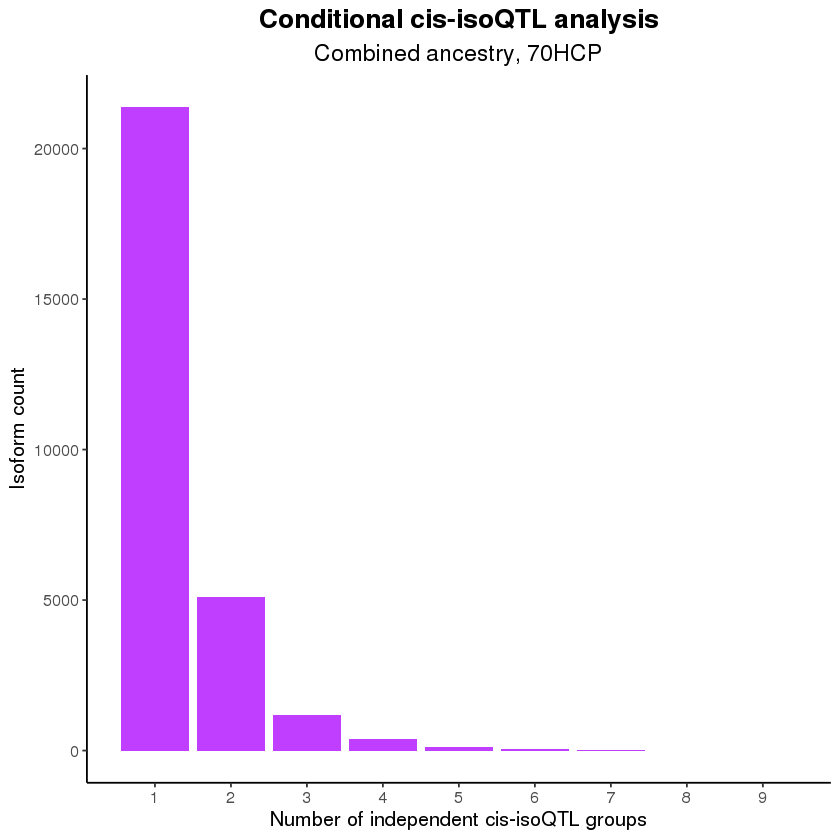

In [29]:
df_cond <- data.frame("isoform" <- unique(dat$V1),
                      "num_rank" <- NA)
for (i in 1:nrow(df_cond)) {
  isoform <- df_cond[i,1]
  df_cond[i,2] <- max(dat[dat$V1==isoform,12]) + 1
}
names(df_cond) <-c("isoform","num_rank")

p <- ggplot(df_cond, aes(x=num_rank)) +
  geom_bar(fill="darkorchid1") +
  scale_x_continuous(breaks = seq(1,9,by=1)) +
  labs(x="Number of independent cis-isoQTL groups", y="Isoform count") +
  ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p

In [30]:
table(df_cond$num_rank)


    1     2     3     4     5     6     7     8     9 
21373  5109  1167   391   107    36     8     2     2 

In [19]:
ggsave("figures/condition_rank.png", p, height=6, width=6)

**Primary and seconday distance to TSS**

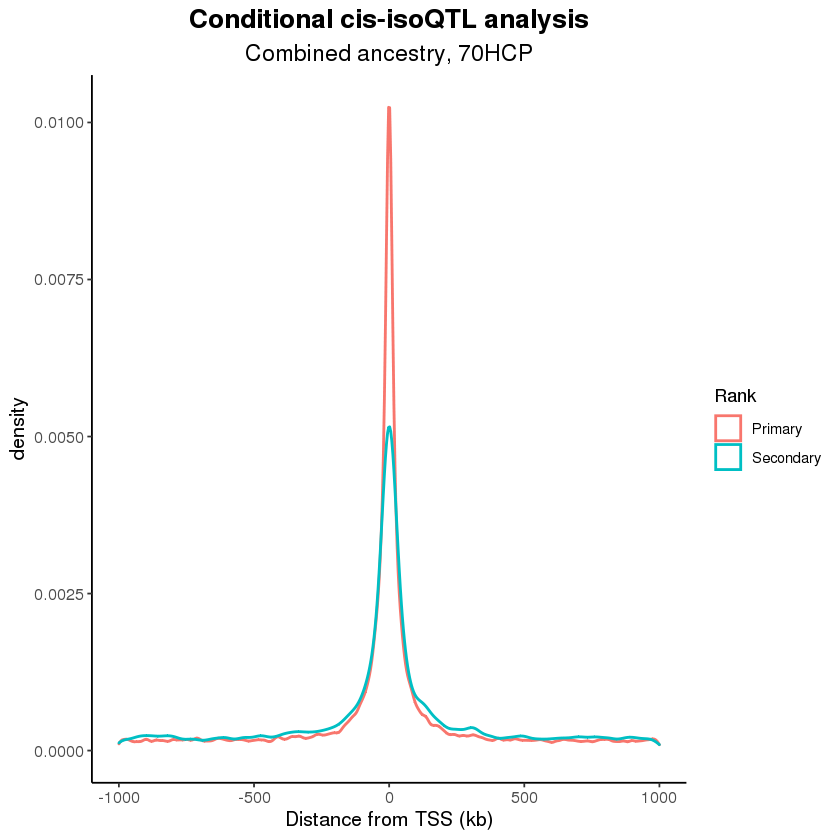

In [20]:
dat2 <- filter(dat, V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0, "Primary", "Secondary")

p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
  geom_density(size=.8) +
  labs(x="Distance from TSS (kb)") +
  ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p2

In [21]:
ggsave("figures/condition_dtss.png", p2, height=6, width=6)

In [22]:
table(dat2$Rank)


  Primary Secondary 
    27285      6816 

In [23]:
primary <- dat2 %>% filter(Rank == "Primary")
secondary <- dat2 %>% filter(Rank == "Secondary")
median(primary$tss_kb)
median(secondary$tss_kb)

[1] -0.183

[1] 0.014

** wilcox test on TSS absolute values**

In [24]:
wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 81104348, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


### 9: SuSiE results

- We started with 22891 isoTx identified by FastQTL permutation pass for mixed ancestries with 70 HCP in covariates
- After filtering for CS purity: 
    - 18111 isoforms have non-low purity CS
    - 23211 unique CS
    - 225,218 unique variants in CS    
- Of the 23211 CS:
    - 4702 contain exactly one SNP (strong candidates for causal variants)
    - 2614 contain exactly two SNPs
    - median size 5
- Of the 18111 isoforms:
    - 14380 have exactly one CS
    - up to 7

** File: all variants that belong to a non-low purity credible set **

Other files: 
- all credible sets (not filtered for purity)
- all tested variants

In [3]:
var_in_cs <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 423607     17

** How many isoforms got finemapped non-low purity credible sets?**

In [4]:
length(unique(var_in_cs$phenotype_id))

[1] 18111

** How many unique variants in all CS? **

In [5]:
length(unique(var_in_cs$variant_id))

[1] 225218

** How many unique non-low purity CS?**

In [6]:
length(unique(var_in_cs$cs_id))

[1] 23211

**  Sorted by chr and pos of isoforms **

In [7]:
sorted_df <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm_purity_filtered.txt.gz", data.table = F)

** How many CS contain exactly one SNP? **

In [8]:
cs_id_size <- sorted_df[!duplicated(sorted_df$cs_id),] %>% select(cs_id, cs_size, finemapped_region)

In [9]:
sum(cs_id_size$cs_size==1)
sum(cs_id_size$cs_size==2)

[1] 4702

[1] 2614

In [11]:
summary(cs_id_size$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   18.25   15.00 2164.00 

** Note chr 17 region has large CS **

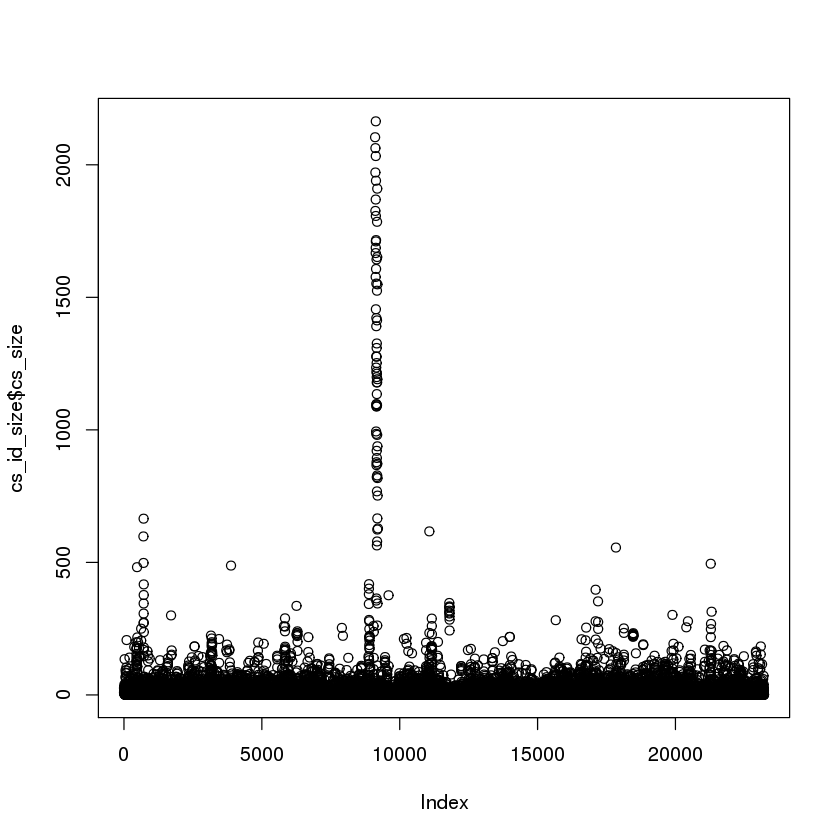

In [12]:
plot(cs_id_size$cs_size)

In [13]:
cs_id_size %>% filter(cs_size > 500)

cs_id,cs_size,finemapped_region
<chr>,<int>,<chr>
ENST00000621900.1_1_L1,598,chr10:73885289-75885289
ENST00000488223.5_1_L1,665,chr10:73870216-75870216
ENST00000587960.1_1_L3,2104,chr17:42608942-44608942
ENST00000329196.7_2_L1,1826,chr17:42922246-44922246
ENST00000585677.1_1_L1,1971,chr17:42716340-44716340
ENST00000570299.5_1_L1,2063,chr17:42971941-44971941
ENST00000638269.1_2_L2,1577,chr17:43302726-45302726
ENST00000592428.1_2_L1,1667,chr17:42716802-44716802
ENST00000577114.2_3_L2,1869,chr17:43198703-45198703


** How many isoforms have exactly one CS? **

In [14]:
iso_with_cs <- unique(sorted_df$phenotype_id)
df <- data.frame("isoform" = iso_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df[sorted_df$phenotype_id == df[i,1],]$cs_id))
}

In [15]:
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.282   1.000   7.000 

[1] 14380

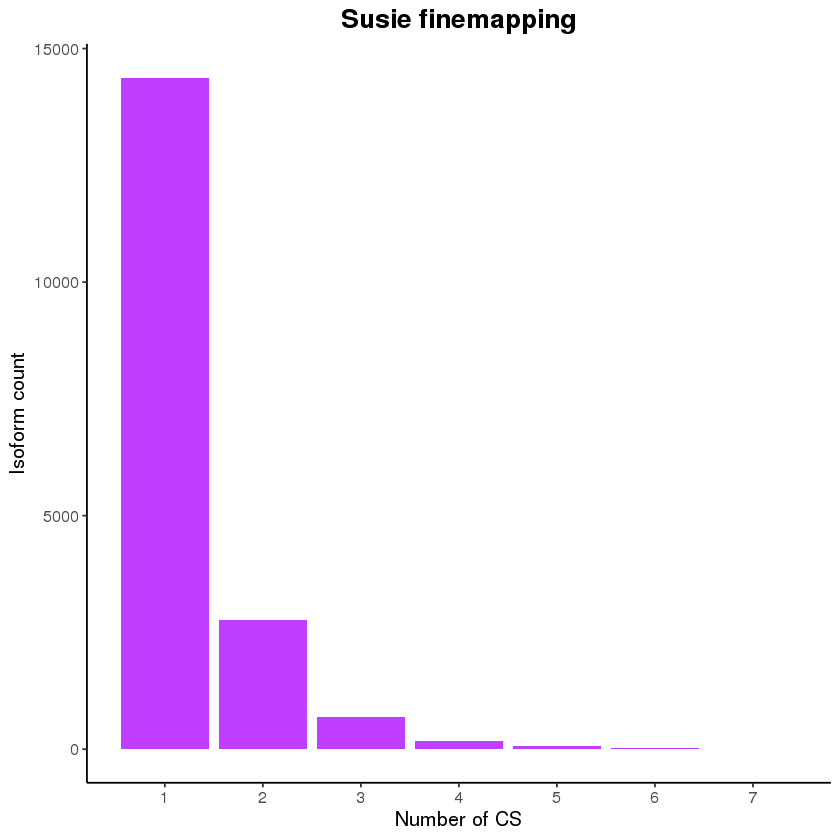

In [17]:
p <- ggplot(df, aes(x=cs_count)) +
  geom_bar(fill="darkorchid1") +
  scale_x_continuous(breaks = seq(1,7,by=1)) +
  labs(x="Number of CS", y="Isoform count") +
  ggtitle("Susie finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p

In [20]:
ggsave("figures/susie_num_cs.png", p, width = 6, height = 6)

** Number of independent signals compared to conditional QTL mapping**

In [31]:
head(df)
head(df_cond)

,isoform,cs_count
,<fct>,<int>
1,ENST00000370584.7_3,1
2,ENST00000370575.5_3,2
3,ENST00000464808.1_2,1
4,ENST00000325103.10_3,1
5,ENST00000467246.5_2,1
6,ENST00000483923.5_2,1


,isoform,num_rank
,<fct>,<dbl>
1,ENST00000440313.2_2,1
2,ENST00000545249.5_2,1
3,ENST00000537656.1_1,1
4,ENST00000645650.1_2,1
5,ENST00000544683.5_3,1
6,ENST00000536918.1_2,1


In [32]:
sum(df$isoform %in% df_cond$isoform)

[1] 16874

In [33]:
df2 <- df %>% inner_join(df_cond)
sum(complete.cases(df2))
dim(df2)

Joining, by = "isoform"



[1] 16874

[1] 16874     3

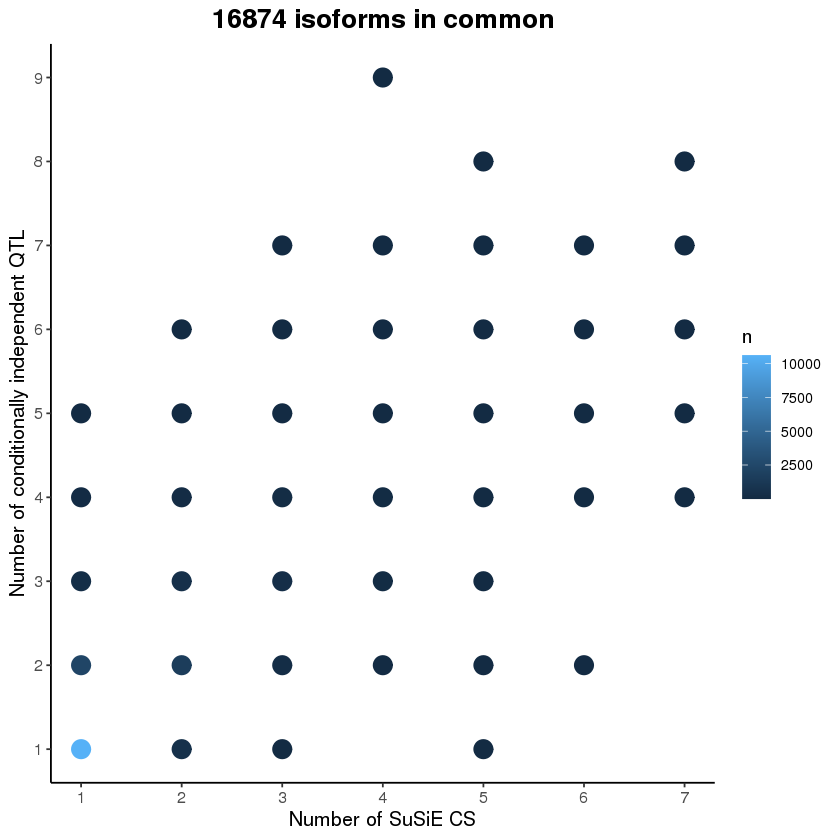

In [34]:
p <- ggplot(df2, aes(x=cs_count, y=num_rank)) +
#   geom_count(color = "steelblue1") +
  geom_count(aes(color = ..n..), size=5) +
#   scale_size_area() + 
#   geom_hex() +
  labs(x="Number of SuSiE CS", y="Number of conditionally independent QTL") +
  ggtitle("16874 isoforms in common") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) 
p

In [35]:
ggsave("figures/susie_conditional.png", p, width=6, height=6)

** sum of PIP in CS **

In [36]:
cs_sum_pip <- sorted_df %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

`summarise()` ungrouping output (override with `.groups` argument)



    cs_id              sum_pip      
 Length:23211       Min.   :0.9500  
 Class :character   1st Qu.:0.9639  
 Mode  :character   Median :0.9777  
                    Mean   :0.9815  
                    3rd Qu.:0.9978  
                    Max.   :1.8221  